# Data Sourcing, Preliminary Data Analysis, and Centrality Ranking Construction


In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from PMFG_mod import PMFG

from time import time
import timeit

#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data Description
For this project, we use S&P500 constituents daily returns from start-of-year 2016 to end-of-year 2019.  We retrieved and preprocessed the data from CRSP database via WRDS.

In [2]:
# S&P constituents return data
use_IVV = False

if use_IVV:
    raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')

    log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
    # drop first row of raw prices so it has the same dimensions as the log-returns DF
    raw_asset_prices_df = raw_asset_prices_df.iloc[1:]
    stock_names = log_returns_df.columns

    df_shape = (raw_asset_prices_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")

    print(log_returns_df.head())
else:
    log_returns_df = pd.read_excel("data/historical_2016_2019.xlsx", index_col='Names Date')
    stock_names = log_returns_df.columns   # this is just simple returns, not log -- but whatevs
    df_shape = (log_returns_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {log_returns_df.index[0]} to {log_returns_df.index[-1]}")
    
ticker_names = log_returns_df.columns

There are 1006 rows and 485 columns in the dataset.
Data timeperiod covers: 2016-01-04 00:00:00 to 2019-12-31 00:00:00


In [3]:
log_returns_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Names Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.026788,-0.034002,0.011494,0.000855,-0.027515,-0.017742,-0.055826,-0.044088,-0.025550,-0.020971,...,-0.005848,-0.024910,-0.006286,-0.032703,-0.011507,-0.011499,-0.007603,-0.045370,-0.021612,-0.013564
2016-01-05,-0.003441,-0.009533,-0.006831,-0.025059,-0.004166,0.014626,-0.002816,-0.000233,0.005205,0.004023,...,0.010084,0.014847,0.008521,0.020387,-0.000277,-0.002493,0.020823,-0.025117,-0.010857,0.015655
2016-01-06,0.004439,0.017522,-0.026455,-0.019570,0.000174,-0.015286,0.003529,-0.008388,-0.001954,-0.014295,...,0.010538,-0.018287,-0.008321,-0.014486,-0.012476,-0.007080,0.004330,-0.039957,-0.029145,0.000208
2016-01-07,-0.042475,-0.018918,0.011073,-0.042205,-0.002963,-0.031932,-0.039625,-0.023966,-0.029366,-0.020984,...,0.003842,-0.039448,-0.016006,-0.008785,-0.025828,-0.034116,-0.022993,-0.045316,-0.030020,-0.030404
2016-01-08,-0.010513,-0.001978,-0.021971,0.005288,-0.027268,-0.005785,0.032471,-0.020944,-0.009681,-0.014140,...,-0.010935,-0.020534,-0.020202,-0.028635,-0.009510,-0.013607,-0.004217,-0.002693,-0.011254,-0.014605


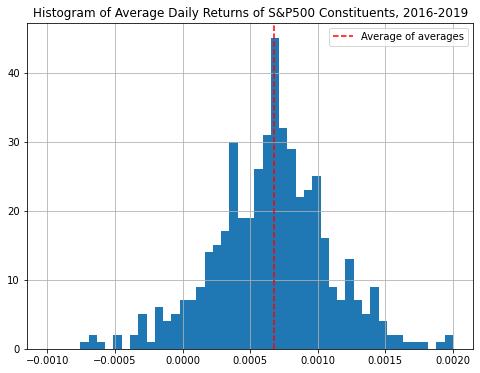

In [4]:
plt.figure(figsize=(8,6))
plt.title('Histogram of Average Daily Returns of S&P500 Constituents, 2016-2019')
log_returns_df.mean().hist(bins=np.linspace(-.001,.002, 50))
plt.axvline(log_returns_df.mean().mean(), color='red', linestyle='--', label = 'Average of averages')
plt.legend()
plt.show();

## Correlation Structure of Returns Data
For this preliminary analysis, we  look at the covariance matrix of stock returns over the entire period. For the other parts of this project, we use the simple covariance matrix of stock returns over a rolling window (~3 months - 1 year). 

In [5]:
raw_corr = log_returns_df.corr()

shr_coef = 1e-4
shr_target=np.eye(df_shape[1])

correlation_matrix = raw_corr*(1-shr_coef) + shr_target*shr_coef
print('Condition number of sample correlation matrix: %.2e' %np.linalg.cond(raw_corr))
print('Condition number of shrunk correlation matrix: %.2e' %np.linalg.cond(correlation_matrix))
correlation_matrix.head()

Condition number of sample correlation matrix: 4.51e+04
Condition number of shrunk correlation matrix: 4.36e+04


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.382898,0.174961,0.423588,0.371440,0.268825,0.370766,0.574714,0.524620,0.524594,...,0.082312,0.390005,0.344952,0.305398,0.495933,0.383953,0.426343,0.385791,0.402954,0.508536
AAL,0.382898,1.000000,0.202168,0.349767,0.212754,0.242920,0.208959,0.356430,0.336261,0.357479,...,-0.061541,0.401709,0.242301,0.195624,0.393245,0.300815,0.274667,0.333879,0.422293,0.330460
AAP,0.174961,0.202168,1.000000,0.155419,0.147060,0.162803,0.134836,0.215587,0.215358,0.151175,...,0.068318,0.154732,0.180567,0.123950,0.209004,0.176603,0.188930,0.172971,0.265356,0.191637
AAPL,0.423588,0.349767,0.155419,1.000000,0.271367,0.206464,0.363831,0.425138,0.461773,0.513189,...,0.031991,0.442036,0.343888,0.223976,0.365499,0.315368,0.321466,0.350361,0.302726,0.384876
ABBV,0.371440,0.212754,0.147060,0.271367,1.000000,0.304759,0.258362,0.431498,0.328579,0.328576,...,0.059929,0.241190,0.292893,0.261174,0.302585,0.199634,0.334430,0.222451,0.278699,0.380533


D:\Anaconda\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


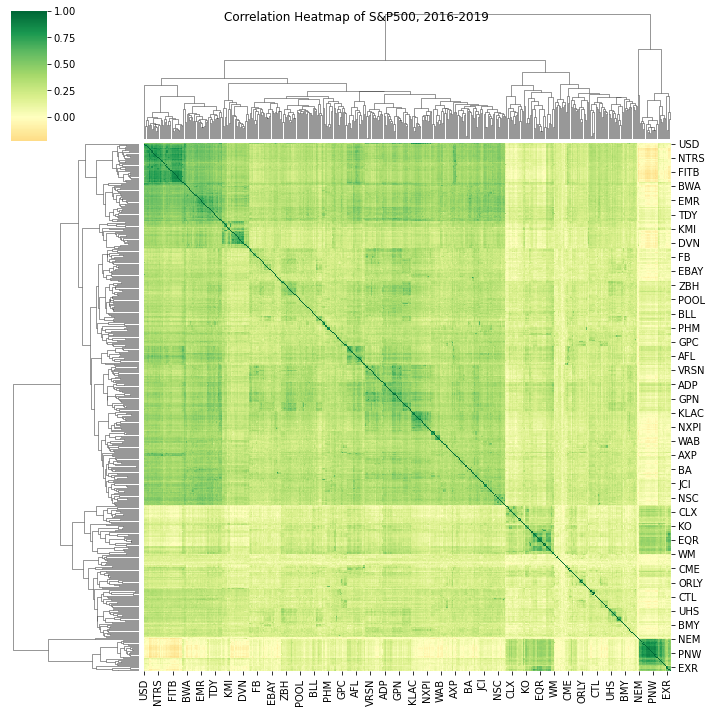

In [6]:
sns.clustermap(correlation_matrix, cmap="RdYlGn", center =0.).fig.suptitle('Correlation Heatmap of S&P500, 2016-2019');

## Graph Filtering: Pipeline
We follow the construction from Pozzi et al.

Pipeline:
1. Construct correlation matrix
2. Construct dense network graph using off-diagonal correlation values as edge weights
5. Filter the dense network. Examples of filtering algorithm:
    * Minimum Spanning Tree
    * Planar Maximally Filtered Graph
    * Binarize edge weights by threshold value
4. Report centrality/peripherality measures for each node. Examples:
    * Betweeness-centrality
    * Eigen-centrality
    * PageRank
    * Closeness
    * Eccentricity
5. Aggregate the measures; analyze and compose a hybrid centrality index

### Graph Construction
(Intro to MST and PMFG)

In [7]:
# dense network graph
G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))

timestamp = time()
G0_filtered = PMFG(G0).compute(tol_ratio=.03)
print('Time taken to construct PMFG graph: %.2f s\n' %(time()-timestamp))
print('Summary stats of filtered graph:')
print(nx.info(G0_filtered))

Time taken to construct PMFG graph: 58.13 s

Summary stats of filtered graph:
Name: 
Type: Graph
Number of nodes: 476
Number of edges: 1406
Average degree:   5.9076


Here are some visualizations of the filtered graph. Notice that the spectral embedding exhibits a trefold structure, suggesting a three-cluster correlation structure. Worth a deeper look into this, but unfortunately we will have to let this apss due to time constraint.

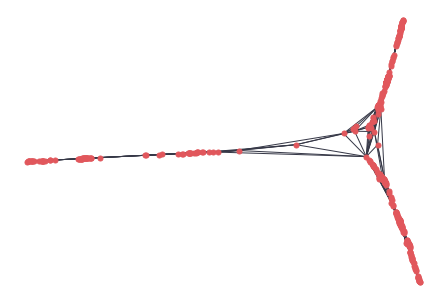

In [8]:
nx.draw(G0_filtered, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(G0_filtered))

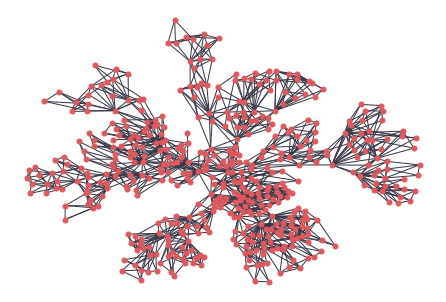

In [9]:
nx.draw(G0_filtered, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G0_filtered))

## Centrality Measures

A brief overview of centrality measures:

#### Degree Centrality
The degree of a node can be considered a measure of centrality. Indeed, the higher the degree of a node, the more "important" a node is, and therefore it is considered more "central".

For a directed graph, one would need to make a distinction between in-degree and out-degree and therefore also the in/out-degree centrality. But for our project, the networks we consider are all undirected (as correlations are bi-directional).

#### Eigenvector Centrality
TODO: Spectral embedding & graph (adjacency) spectrum; quadratic maximisation problem; Perron-Frobenus on existence of unique sol (and PMFG by construction satisfies the assumptions (aperiodic irreducible/strongly-connected).

#### PageRank
Eigen centrality on in-degree-normalized adjacency matrix (i.e. the random walk matrix). Do note that the graphs we are considering in this project are all bi-directional and strongly connected. Hence these graphs are aperiodic-irreducible when plugged into PageRank, and all the Frobenius-Perron uniqueness/convergence holds nicely.

Pagerank gives a physical meaning to the eigenproblem: casting the eigendecomposition problem into a random walk problem
the eigenvector -- (unique) equilibrium random-walk distribution.

#### Eccentricity
The eccentricity of a vertex is the maximum distance between itself and any other vertex in the graph. The radius of a graph is its minimum eccentricity; the diameter of a graph is its maximum eccentricity. 

Eccentricity is a **peripherality** measure, not centrality measure. The higher the eccentricity of a node, the farther it is away it is from its "center", and therefore the more peripheral/less central it is. 

### Closeness Centrality
(assumes connecteness)

The farness of a vertex in a graph is the average of shortest paths between the said node and all other nodes. The closeness is the reciprocal of farness.

More "central" a node is ==> shorter its distance to all other vertices ==> lower farness/higher closeness

#### Betweenness Centrality
The ratio of shortest paths passing through a certain vertex, w.r.t. all shortest paths in the graph.

The more "central" a node is, the more likely a shortest path has to pass through it, and the higher its betweenness ratio is.


In [10]:
use_weighted = True

if use_weighted:
    G1 = nx.Graph()
    weight_map = lambda w: 1+w
    for u,v,d in G0_filtered.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    deg= pd.DataFrame.from_dict(dict(G1.degree(weight='weight')), orient='index', columns = ['D'])
    EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G1, weight='weight', max_iter=1000), orient='index', columns = ['EC'])
    PG = pd.DataFrame.from_dict(nx.pagerank(G1, weight='weight'), orient='index', columns = ['PG'])
    
    G1 = nx.Graph()
    weight_map = lambda w: np.sqrt(2*(1-w))
    for u,v,d in G0_filtered.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    ecc= pd.DataFrame.from_dict(nx.eccentricity(G1), orient='index', columns = ['E'])
    clo= pd.DataFrame.from_dict(nx.closeness_centrality(G1, distance='weight'), orient='index', columns = ['C'])
    BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G1, weight='weight'), orient='index', columns = ['BC'])
else:
    deg= pd.DataFrame.from_dict(dict(G1.degree(weight=None)), orient='index', columns = ['D'])
    EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G1, weight=None, max_iter=1000), orient='index', columns = ['EC'])
    PG = pd.DataFrame.from_dict(nx.pagerank(G1, weight=None), orient='index', columns = ['PG'])
    ecc= pd.DataFrame.from_dict(nx.eccentricity(G1), orient='index', columns = ['E'])
    clo= pd.DataFrame.from_dict(nx.closeness_centrality(G1, distance=None), orient='index', columns = ['C'])
    BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G1, weight=None), orient='index', columns = ['BC'])

In [11]:
centralities_names = ['D', 'BC', 'nE', 'C', 'EC', 'PG']
cen_longnames = ['Degree','Betweenness Centrality','Negative Eccentricity','Closeness Centrality','Eigen-Centrality','PageRank']

centralities = deg.copy().rename(columns={'D':'Degree'})
centralities['Betweenness Centrality'] = BC
centralities['Negative Eccentricity']  = -ecc
centralities['Closeness Centrality']  = clo
centralities['Eigen-Centrality'] = EC
centralities['PageRank'] = PG

centralities.head()

,Degree,Betweenness Centrality,Negative Eccentricity,Closeness Centrality,Eigen-Centrality,PageRank
GOOG,9.985092,0.000009,-9,0.223746,0.051293,0.002277
GOOGL,13.286709,0.004308,-9,0.224067,0.065243,0.002913
MSFT,42.239765,0.090455,-8,0.264364,0.216680,0.008728
AMZN,9.524285,0.000018,-9,0.217980,0.037174,0.002242
V,45.430091,0.036669,-9,0.243207,0.172746,0.009571


We observe a block structure among these centrality measures. Degree, PageRank and betweenness-centrality have very high correlations (Pearson and Spearman) with each other, and eigen-centrality, closeness and negative eccentricity have very high correlations with each other as well, but correlations across the two groups are much lower.

The Pearson and Spearman correlations heatmaps of centrality features are produced below. The clustering effect is more obvious when we inspect the Spearman correlations, as the centrality features are heavily skewed and have heterogenous distributions.

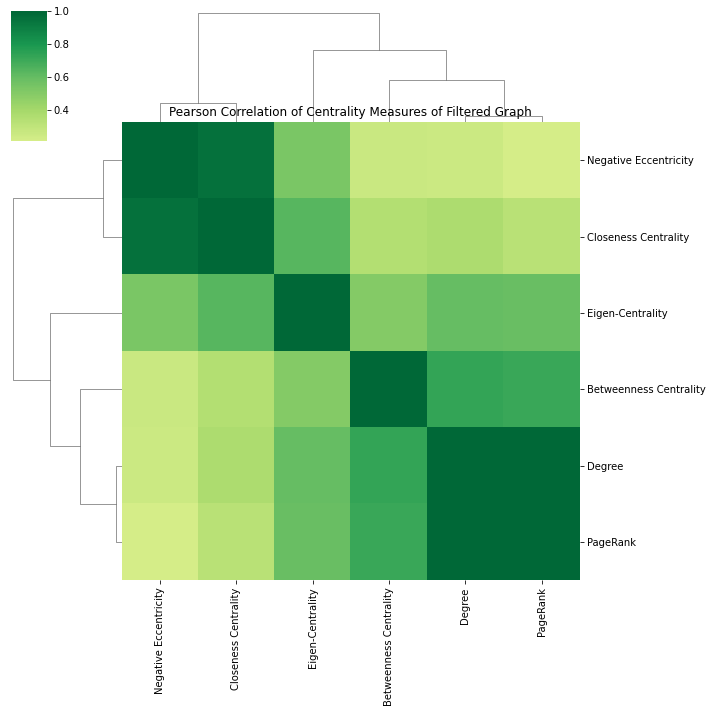

,Degree,Betweenness Centrality,Negative Eccentricity,Closeness Centrality,Eigen-Centrality,PageRank
Degree,1.000000,0.733685,0.255678,0.374379,0.600335,0.995146
Betweenness Centrality,0.733685,1.000000,0.263314,0.350315,0.503021,0.715500
Negative Eccentricity,0.255678,0.263314,1.000000,0.954115,0.532725,0.211540
Closeness Centrality,0.374379,0.350315,0.954115,1.000000,0.637114,0.327373
Eigen-Centrality,0.600335,0.503021,0.532725,0.637114,1.000000,0.591957
PageRank,0.995146,0.715500,0.211540,0.327373,0.591957,1.000000


In [12]:
testsup=sns.clustermap(centralities.corr(), cmap="RdYlGn", center=0.)
testsup.ax_heatmap.set_title('Pearson Correlation of Centrality Measures of Filtered Graph')
plt.show()
(centralities.corr())

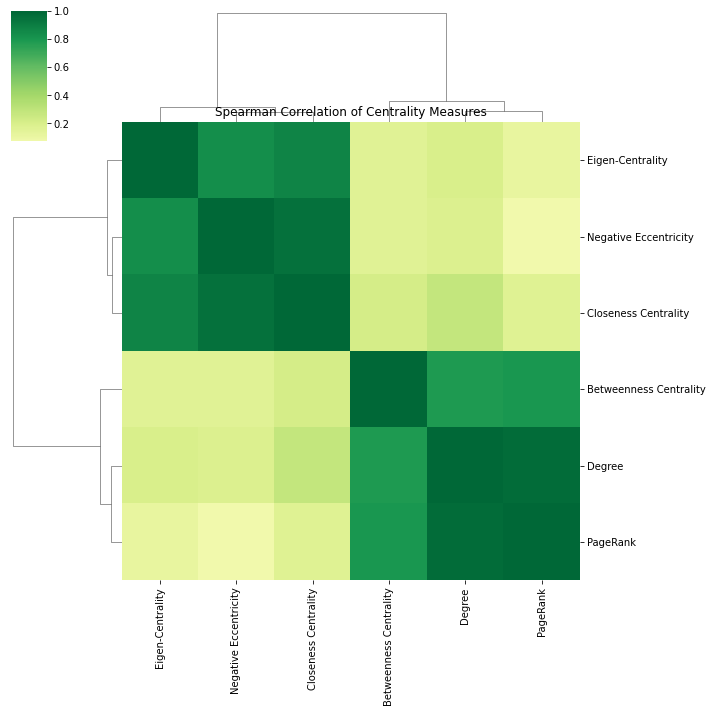

,Degree,Betweenness Centrality,Negative Eccentricity,Closeness Centrality,Eigen-Centrality,PageRank
Degree,1.000000,0.787257,0.182905,0.285980,0.201538,0.976177
Betweenness Centrality,0.787257,1.000000,0.159961,0.221269,0.163196,0.802089
Negative Eccentricity,0.182905,0.159961,1.000000,0.958405,0.836799,0.077686
Closeness Centrality,0.285980,0.221269,0.958405,1.000000,0.878353,0.173503
Eigen-Centrality,0.201538,0.163196,0.836799,0.878353,1.000000,0.124996
PageRank,0.976177,0.802089,0.077686,0.173503,0.124996,1.000000


In [13]:
from scipy.stats import spearmanr
cen_spcorr = pd.DataFrame(spearmanr(centralities).correlation, index=cen_longnames, columns=cen_longnames)

testsup=sns.clustermap(cen_spcorr, cmap="RdYlGn", center=0.)
testsup.ax_heatmap.set_title('Spearman Correlation of Centrality Measures')
plt.show()
cen_spcorr

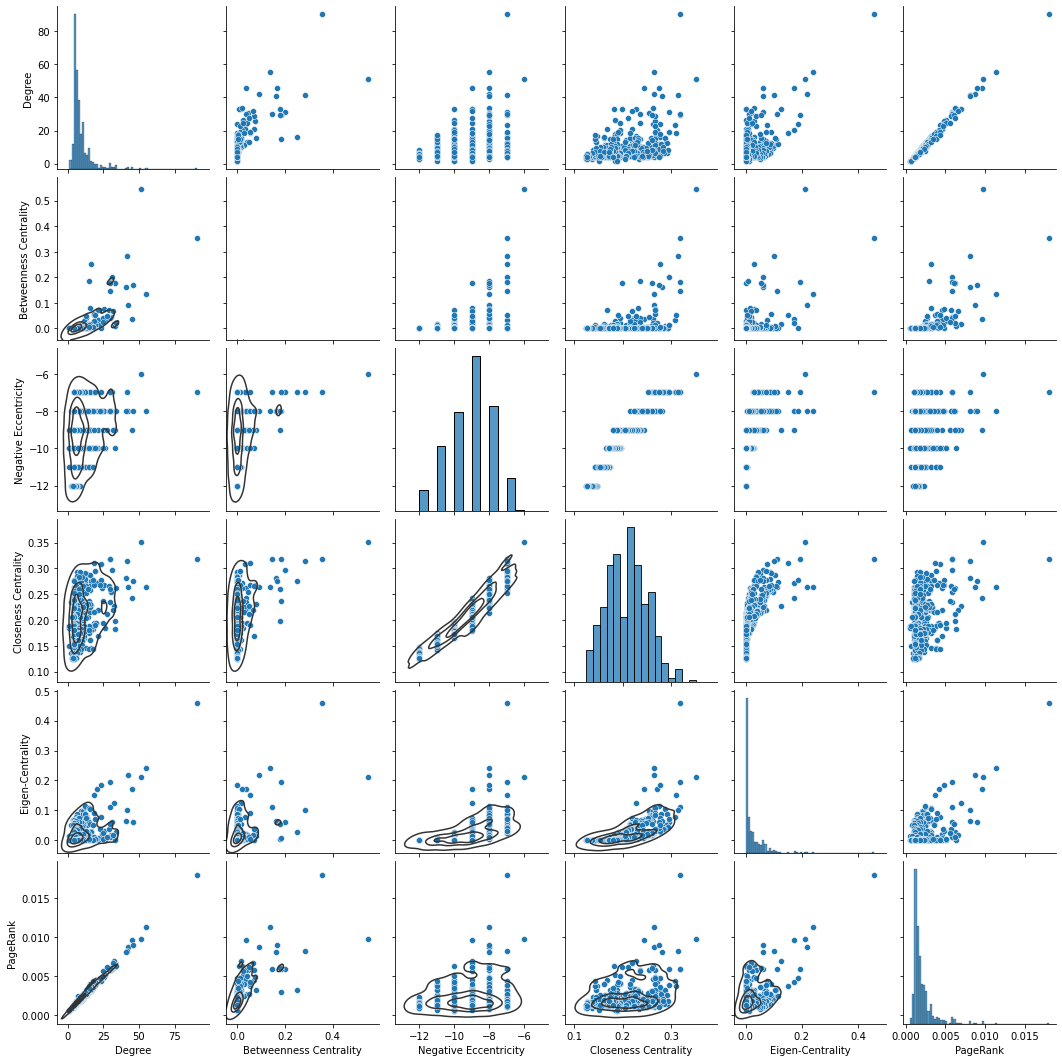

In [14]:
corr_plot = sns.pairplot(data=centralities)
corr_plot.map_lower(sns.kdeplot, levels=4, color=".2");

## Aggregating Multiple Centralities Measures
As observed in the correlation heatmaps above, the centrality measures has two separate clusters, with very high in-cluster correlation. As per Pozzi et al, we first compute the X/Y indices by averaging the ranking of centrality measures for each cluster: i.e. we have an "X ranking" which is the average ranking of PageRank and eigen-centrality, and "Y ranking" is the average ranking of negative eccentricity, closeness centrality and betweenness centrality. Then, use the average of X and Y ranking as our aggregated "XY" centrality index.

PMFG construction is costly, so we save our XY rankings (recalculated quarterly) into a .csv to avoid recomputations.

In [15]:
def XY_ranking(G):
    G1 = nx.Graph()
    weight_map = lambda w: 1+w
    for u,v,d in G.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    #deg= pd.DataFrame.from_dict(dict(G1.degree(weight='weight')), orient='index', columns = ['D'])
    #deg_ranking = deg['D'].argsort().argsort()
    PG_ranking = pd.Series(nx.pagerank(G1, weight='weight')).rank()  # almost identical to degree
    EC_ranking = pd.Series(nx.eigenvector_centrality(G1, weight='weight', max_iter=1000)).rank()
    
    G1 = nx.Graph()
    weight_map = lambda w: np.sqrt(2*(1-w))
    for u,v,d in G0_filtered.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    NE_ranking = (-pd.Series(nx.eccentricity(G1))).rank()
    CLO_ranking = pd.Series(nx.closeness_centrality(G1, distance='weight')).rank()
    BC_ranking = pd.Series(nx.betweenness_centrality(G1, weight='weight')).rank()
    
    X = (PG_ranking + BC_ranking).rank()
    Y = (NE_ranking + CLO_ranking + EC_ranking).rank()
    return X,Y,(X+Y).rank()


In [16]:
tx,ty,txy = XY_ranking(G0_filtered)

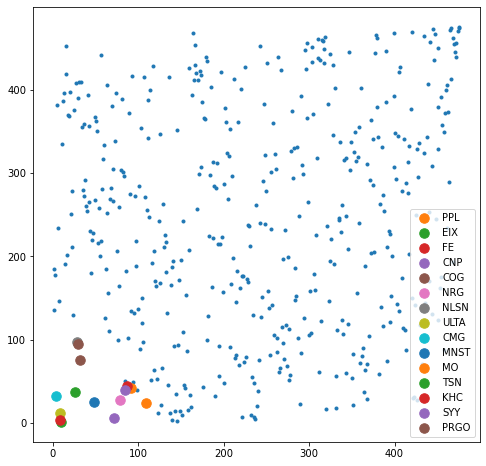

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(tx,ty, marker='.')
#for tick in txy.index[txy> len(txy)-15]:
for tick in txy.index[txy<=15]:
    plt.scatter(tx[tick],ty[tick], s=90, label=tick)
plt.legend();

In [42]:
# wrap the whole correlation construction into one function?
def shrinkage_estimator(corr, shrinkage_coef):
    shrinkage_target=np.eye(corr.shape[1])
    return corr*(1-shrinkage_coef) + shrinkage_target*shrinkage_coef

class XY_constructor:
    def __init__(self, basket_size, basket_update_frequency, rebalance_frequency, rolling_window):
        self.basket_size=  basket_size
        assert basket_update_frequency >= rebalance_frequency
        self.basket_update_frequency = basket_update_frequency
        self.rebalance_frequency     = rebalance_frequency
        self.rolling_window          = rolling_window
    
    def get_XYs(self, data, verbose = False):
        T, n = data.shape
        
        df_Xs = pd.DataFrame(columns=ticker_names)
        df_Ys = pd.DataFrame(columns=ticker_names)
        df_XYs = pd.DataFrame(columns=ticker_names)
        
        for t in range(self.rolling_window, T-1):
            if (t - self.rolling_window)%self.basket_update_frequency == 0:
                timestamp = time()
                corr   = shrinkage_estimator(data.iloc[t - self.rolling_window:t].corr(), 1e-4)
                G      = nx.from_pandas_adjacency(corr - np.diag(np.diag(corr)))
                G      = PMFG(G).compute(tol_ratio=.03)   # do not save dense corr-network
                X,Y,XY = XY_ranking(G)
                timestamp = time() - timestamp
                
                if verbose:
                    print('\nRecomputing filtered network at ', data.index[t])
                    print('Time taken: %.2f\n' %timestamp)
            
            # might want to save only @ dates when the basket is rebalanced
            df_Xs.loc[data.index[t]] = X
            df_Ys.loc[data.index[t]] = Y
            df_XYs.loc[data.index[t]] = XY
            
        return df_Xs, df_Ys, df_XYs
    


In [43]:
# basket size 30, quarterly rebalance, 1y rolling window for est.
t_back = XY_constructor(30, 63, 1, 252)
tXs, tYs, tXYs = t_back.get_XYs(log_returns_df, verbose=True)


Recomputing filtered network at  2017-01-03 00:00:00
Time taken: 68.72


Recomputing filtered network at  2017-04-04 00:00:00
Time taken: 65.67


Recomputing filtered network at  2017-07-05 00:00:00
Time taken: 53.03


Recomputing filtered network at  2017-10-03 00:00:00
Time taken: 44.23


Recomputing filtered network at  2018-01-03 00:00:00
Time taken: 48.65


Recomputing filtered network at  2018-04-05 00:00:00
Time taken: 69.93


Recomputing filtered network at  2018-07-05 00:00:00
Time taken: 65.41


Recomputing filtered network at  2018-10-03 00:00:00
Time taken: 61.36


Recomputing filtered network at  2019-01-04 00:00:00
Time taken: 63.10


Recomputing filtered network at  2019-04-05 00:00:00
Time taken: 71.73


Recomputing filtered network at  2019-07-08 00:00:00
Time taken: 74.64


Recomputing filtered network at  2019-10-04 00:00:00
Time taken: 70.20



In [60]:
tXs.to_csv('X_rankings.csv', index_label='Date')
tYs.to_csv('Y_rankings.csv', index_label='Date')
tXYs.to_csv('XY_rankings.csv', index_label='Date')
